<a href="https://colab.research.google.com/github/ppkgtmm/emotion/blob/BiGRU/emo_biGRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !pip install -q keras-tuner
# !rm -r emotion
# !git clone --branch BiGRU https://github.com/ppkgtmm/emotion.git emotion

In [3]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import  Tokenizer
from emotion.models import utils, bigru
from kerastuner.tuners.bayesian import BayesianOptimization
from kerastuner import HyperParameters

In [4]:
num_words = 15000
max_len = 300
hp = HyperParameters()
hp.Choice('output_dim',[128, 256])
hp.Choice('optimizer', ['adam', 'amsgrad'])
hp.Choice('gru_units', [16, 32, 64])
hp.Fixed('max_len', max_len)
hp.Fixed('num_words', num_words)
seed = 1234

In [6]:
train, test = utils.read_and_split()
train.sample(5)

,text,target
13668,i feel that way but yeah i do have a problem i...,joy
19845,i do that made me feel excited about life,joy
17273,i wanted to pen it down for memory sake but i ...,sadness
16773,i don t know why i should feel humiliated to w...,sadness
14514,i am in italy and i feel as useless as i could...,sadness


In [7]:
tokenizer = Tokenizer(num_words=num_words, oov_token='OOV')
tokenizer.fit_on_texts(train['text'])

In [8]:
sequence_train = utils.get_sequences(tokenizer, train['text'], max_len)
sequence_test = utils.get_sequences(tokenizer, test['text'], max_len)

In [9]:
target_train = utils.OH_fit_transform(train['target'])
target_test = utils.OH_transform(test['target'])

In [10]:
tuner = BayesianOptimization( bigru.build_bigru,
                              'val_accuracy',
                              12,
                              executions_per_trial=2,
                              hyperparameters=hp, 
                              seed=seed,
                              num_initial_points=5,
                              project_name='/content/drive/MyDrive/__ed__/bigru_B32',
                            )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 128)          1920000   
_________________________________________________________________
bidirectional (Bidirectional (None, 32)                14016     
_________________________________________________________________
dense (Dense)                (None, 6)                 198       
Total params: 1,934,214
Trainable params: 1,934,214
Non-trainable params: 0
_________________________________________________________________


In [11]:
history = tuner.search(
            sequence_train, target_train,
            validation_split=0.1,
            epochs=3)

Trial 12 Complete [00h 03m 32s]
val_accuracy: 0.9314706027507782

Best val_accuracy So Far: 0.9364705979824066
Total elapsed time: 00h 34m 29s
INFO:tensorflow:Oracle triggered exit


In [23]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
output_dim (Choice)
{'default': 128, 'conditions': [], 'values': [128, 256], 'ordered': True}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'amsgrad'], 'ordered': False}
gru_units (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
max_len (Fixed)
{'conditions': [], 'value': 300}
num_words (Fixed)
{'conditions': [], 'value': 15000}


In [24]:
tuner.results_summary(num_trials=3)

Results summary
Results in /content/drive/MyDrive/__ed__/bigru_B32
Showing 3 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
output_dim: 128
optimizer: adam
gru_units: 64
max_len: 300
num_words: 15000
Score: 0.9364705979824066
Trial summary
Hyperparameters:
output_dim: 256
optimizer: amsgrad
gru_units: 64
max_len: 300
num_words: 15000
Score: 0.9344117641448975
Trial summary
Hyperparameters:
output_dim: 256
optimizer: amsgrad
gru_units: 64
max_len: 300
num_words: 15000
Score: 0.9338235259056091


In [12]:
best_model = tuner.get_best_models(num_models=1)[0]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 128)          1920000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               74496     
_________________________________________________________________
dense (Dense)                (None, 6)                 774       
Total params: 1,995,270
Trainable params: 1,995,270
Non-trainable params: 0
_________________________________________________________________


94/94 [==============================] - 1s 11ms/step
Accuracy:	92.5%


              precision    recall  f1-score   support

       anger       0.93      0.91      0.92       406
        fear       0.87      0.93      0.90       356
         joy       0.96      0.92      0.94      1014
        love       0.83      0.86      0.84       246
     sadness       0.95      0.98      0.96       870
    surprise       0.84      0.71      0.77       108

    accuracy                           0.92      3000
   macro avg       0.89      0.89      0.89      3000
weighted avg       0.93      0.92      0.92      3000



<Figure size 432x288 with 0 Axes>

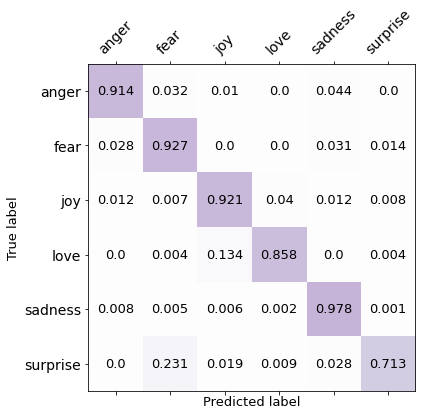

In [13]:
utils.model_evaluate(best_model, sequence_test, target_test, 32)

In [14]:
model = bigru.build_bigru(tuner.get_best_hyperparameters(num_trials=1)[0])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 128)          1920000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               74496     
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 774       
Total params: 1,995,270
Trainable params: 1,995,270
Non-trainable params: 0
_________________________________________________________________


In [15]:
cb = utils.get_callbacks('best_bigru.h5')

In [16]:
history = model.fit(
    sequence_train, 
    target_train, 
    validation_split=0.1, 
    epochs=100,
    callbacks=cb
     )

Epoch 1/100
479/479 [==============================] - 22s 41ms/step - loss: 1.3846 - accuracy: 0.4522 - precision_1: 0.6153 - recall_1: 0.1718 - val_loss: 0.2797 - val_accuracy: 0.9194 - val_precision_1: 0.9511 - val_recall_1: 0.8812

Epoch 00001: val_accuracy improved from -inf to 0.91941, saving model to best_bigru.h5
Epoch 2/100
479/479 [==============================] - 19s 39ms/step - loss: 0.1912 - accuracy: 0.9339 - precision_1: 0.9517 - recall_1: 0.9189 - val_loss: 0.1569 - val_accuracy: 0.9282 - val_precision_1: 0.9356 - val_recall_1: 0.9229

Epoch 00002: val_accuracy improved from 0.91941 to 0.92824, saving model to best_bigru.h5
Epoch 3/100
479/479 [==============================] - 19s 39ms/step - loss: 0.0868 - accuracy: 0.9628 - precision_1: 0.9660 - recall_1: 0.9588 - val_loss: 0.1734 - val_accuracy: 0.9282 - val_precision_1: 0.9341 - val_recall_1: 0.9253

Epoch 00003: val_accuracy did not improve from 0.92824
Epoch 4/100
479/479 [==============================] - 19s 4

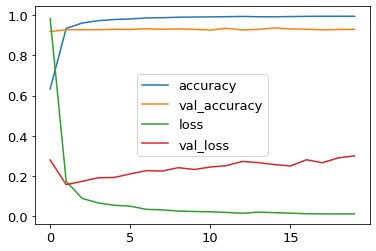

In [19]:
metr = ['accuracy', 'val_accuracy', 'loss', 'val_loss']
pd.DataFrame(history.history)[metr].plot()

In [21]:
# utils.dump(tokenizer, '/content/drive/MyDrive/__ed__/bigru_B32/tokenizer.pickle')
# utils.dump(history.history, '/content/drive/MyDrive/__ed__/bigru_B32/history.pickle')

94/94 [==============================] - 1s 11ms/step
Accuracy:	92.5%


              precision    recall  f1-score   support

       anger       0.92      0.92      0.92       406
        fear       0.91      0.85      0.88       356
         joy       0.94      0.94      0.94      1014
        love       0.84      0.84      0.84       246
     sadness       0.96      0.97      0.97       870
    surprise       0.77      0.81      0.79       108

    accuracy                           0.93      3000
   macro avg       0.89      0.89      0.89      3000
weighted avg       0.93      0.93      0.92      3000



<Figure size 432x288 with 0 Axes>

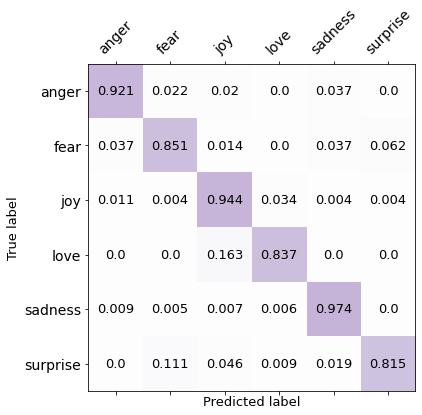

In [25]:
utils.model_evaluate(model, sequence_test, target_test, 32)

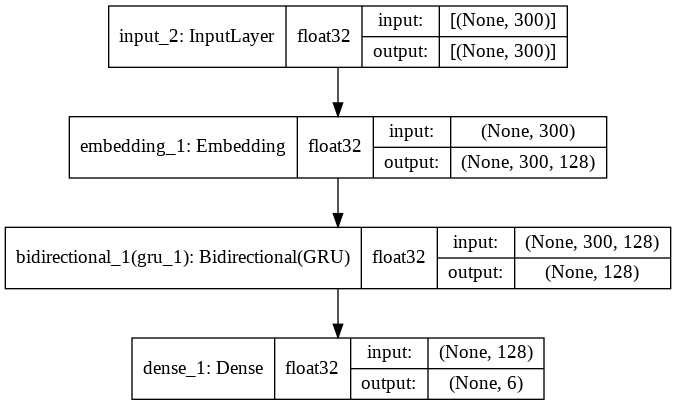

In [22]:
from keras.utils import plot_model
plot_model(
    model,
    to_file='/content/drive/MyDrive/__ed__/bigru_B32/plot.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True
    )